<a href="https://colab.research.google.com/github/connerreinhardt/datascienceprojects/blob/master/SeniorDesign-VenueDataExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
##BEGIN DATA CLEANING
import numpy as np
import pandas as pd

In [7]:
#***LONG RUN TIME: RUN ONLY ONCE***
#Opening the files for each document TODO upload each of the files as CSV so that we can read and parse them

dirFilePath = '/content/drive/My Drive/Colab Notebooks/Senior Design Team 23 Code Lab/'
foodFilePath = dirFilePath + 'FoodData-8-29-19.xlsx'
attendanceFilePath = dirFilePath + 'GameAttendance-11-09-18.xlsx'

#all food data
foodData = pd.read_excel(foodFilePath, sheet_name='Stand')

#all attendance data
attendanceData = pd.read_excel(attendanceFilePath)
print("Data imported...")

Data imported...


In [0]:
#Get vendor locations data
vendorLocationFilePath = dirFilePath + 'VendorBlocks.xlsx'
vendorLocations = pd.read_excel(vendorLocationFilePath)

#save event columns and section columns as strings (because they are mixed int and string initially: e.g. "101","101A")
attendanceData['event_name'] = attendanceData['event_name'].astype(str)
attendanceData['section_name'] = attendanceData['section_name'].astype(str)

#sort for only the basketball games (then remove the H that denotes them)
attendanceData = attendanceData[attendanceData['event_name'].str.contains("H")]
attendanceData['event_name'] = attendanceData['event_name'].map(lambda x: str(x).replace('H',''))

#delete excess day of week information
del foodData['Day']

In [9]:
#***LONG RUN TIME: RUN ONLY ONCE***
#block_name is the name of the restaurant locality blocks that we're predefining
attendanceData['block_name'] = 'NA'

#define block names for floor 1
for i in ['111','112','113','114','115','116']:
    attendanceData.loc[attendanceData['section_name'].str.contains(i),'block_name'] = '1N'
for i in ['117','118','119','120','121']:
    attendanceData.loc[attendanceData['section_name'].str.contains(i),'block_name'] = '1E'
for i in ['122','101','102','103','104','105']:
    attendanceData.loc[attendanceData['section_name'].str.contains(i),'block_name'] = '1S'
for i in ['106','107','108','109','110']:
    attendanceData.loc[attendanceData['section_name'].str.contains(i),'block_name'] = '1W'

#define block names for floor 2
for i in ['213','214','215','216','217','218']:
    attendanceData.loc[attendanceData['section_name'].str.contains(i),'block_name'] = '2N'
for i in ['219','220','221','222','223','224','225','226']:
    attendanceData.loc[attendanceData['section_name'].str.contains(i),'block_name'] = '2E'
for i in ['227','201','202','203','204','205']:
    attendanceData.loc[attendanceData['section_name'].str.contains(i),'block_name'] = '2S'
for i in ['206','207','208','209','210','211','212']:
    attendanceData.loc[attendanceData['section_name'].str.contains(i),'block_name'] = '2W'
print("Block data appended...")

Block data appended...


In [0]:
#add in the block_name information to each vendor on this fooddata list
foodData['block_name'] = 'NA'
#print(vendorLocations.head())
for vendor in vendorLocations['Vendor Name']:
    vendorLoc = vendorLocations.loc[vendorLocations['Vendor Name']==vendor, ['Block']].values[0][0]
    foodData.loc[foodData['Stand']==vendor,'block_name'] = vendorLoc
    
#add in the event date in the same naming convention as attendance
foodData['DateStr'] = pd.to_datetime(foodData['Date'],format='%y%m%d').astype(str)
foodData['DateStr'] = foodData['DateStr'].map(lambda x: str(x).replace('-',''))
foodData.DateStr = foodData.DateStr.str[2:]

#print(foodData.head())
eventList = foodData[['Date','Event','DateStr']].drop_duplicates()
del foodData['Date']
del foodData['Event']

#print(vendorLocations.head())
#print(eventList.head())

In [0]:
#aggregate attendance data for each section
attData = attendanceData.groupby(['event_name','block_name'],as_index=False).agg(
        {
             'entry':"sum",    #sum distinct entering users
             'Distributed': "sum",  #sum total distributed tickets
             'acct_id': 'nunique'  #count distinct users purchasing
        }
)

#print(attData.head()) #search by event name
#print(foodData.head())

In [0]:
#remove rows without a block name in place
foodData = foodData[foodData['block_name'].apply(lambda x: x!='NA')] #remove all rows with block_name "NA"
foodData = foodData.dropna(subset=['block_name']) #remove all rows with block_name "NaN"

In [13]:
#***LONG RUN TIME: RUN ONLY ONCE***
#create the combined dataset dataframe
mergedData = pd.DataFrame(columns = ['eventDesc', 'eventDate', 'DateStr', 'block_name', 'local_attendance', 
                                     'local_ticket_sales', 'local_ticket_buyers',
                                     'Stand','vendor_opening_time', 'Sales', 'Units', 'Txns', 'POS'])

eventDateStrList = eventList['DateStr']

for event in eventDateStrList: #iterate through all events    
    eventDesc = eventList.loc[eventList['DateStr']==event, ['Event']].values[0][0] #name of event
    eventDate = ventDesc = eventList.loc[eventList['DateStr']==event, ['Date']].values[0][0] #event date
    
    eventFoodData = foodData[foodData['DateStr']==event]
    eventAttData = attData[attData['event_name']==event] 
    
    if eventFoodData.empty: ##ERROR - must all be the same length
        print("-> Exclude " + eventDesc + " (" + event + ") due to lacking attendance data.")
    elif eventAttData.empty:
        print("-> Exclude " + eventDesc + " (" + event + ") due to lacking attendance data.")
    
    else: 
        vendorStalls = eventFoodData['Stand'].values
        for vendor in vendorStalls: #go through all vendors
            
            vendorFoodData = eventFoodData[eventFoodData['Stand']==vendor] #find the data from just this event

            vendorBlock = vendorFoodData['block_name'].drop_duplicates().values[0] #vendor location

            localAtt = eventAttData[eventAttData['block_name']==vendorBlock]

            tempDictVendor = vendorFoodData.to_dict('list')
            tempDictAtt = localAtt.to_dict('list')

            dataToAdd = {**tempDictAtt,**tempDictVendor}

            dataToAdd.update({'eventDate' : eventDate})
            dataToAdd.update({'eventDesc' : eventDesc})

            del dataToAdd["event_name"]

            dataToAdd['local_attendance'] = dataToAdd.pop('entry')
            dataToAdd['local_ticket_sales'] = dataToAdd.pop('Distributed')
            dataToAdd['local_ticket_buyers'] = dataToAdd.pop('acct_id')
            dataToAdd['vendor_opening_time'] = dataToAdd.pop('Start')

            dfToAdd = pd.DataFrame(dataToAdd)

            mergedData = pd.concat([mergedData, dfToAdd])

            #print(localAtt)
            #print(vendorFoodData)
#print(mergedData)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



-> Exclude Atlanta Hawks vs Washington Wizards (181218) due to lacking attendance data.
-> Exclude Atlanta Hawks vs Indiana Pacers (181226) due to lacking attendance data.
-> Exclude Atlanta Hawks vs Cleveland Cavaliers (181229) due to lacking attendance data.
-> Exclude Atlanta Hawks vs Miami Heat (190106) due to lacking attendance data.
-> Exclude Atlanta Hawks vs Milwaukee Bucks (190113) due to lacking attendance data.
-> Exclude Atlanta Hawks vs Oklahoma Thunder (190115) due to lacking attendance data.
-> Exclude Atlanta Hawks vs Orlando Magic (190121) due to lacking attendance data.
-> Exclude Atlanta Hawks vs Toranto Raptors (190207) due to lacking attendance data.
-> Exclude Atlanta Hawks vs Charlotte Hornets (190209) due to lacking attendance data.
-> Exclude Atlanta Hawks vs Orlando Magic (190210) due to lacking attendance data.
-> Exclude Atlanta Hawks vs Los Angeles Lakers (190212) due to lacking attendance data.
-> Exclude Atlanta Hawks vs New York Knicks (190214) due to la

In [14]:
pip install xlsxwriter

In [15]:
import xlsxwriter
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('AUTOGEN_merged_output.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
mergedData.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()
print("File is written to disk...")

File is written to disk...


In [16]:
##BEGIN DATA ANALYSIS ********** DON'T EDIT THE PIPELINE BEFORE THIS **********
print(mergedData.head())
for col in mergedData.columns: 
    print(col)

  DateStr POS  Sales  ... local_ticket_buyers local_ticket_sales vendor_opening_time
0  181024   2   4458  ...                 603               1955            19:00:00
0  181024   3   3325  ...                 603               1955            19:00:00
0  181024   6  10885  ...                 409               1662            19:00:00
0  181024   3   1882  ...                 633               1978            19:00:00
0  181024  12   5386  ...                 633               1978            19:00:00

[5 rows x 13 columns]
DateStr
POS
Sales
Stand
Txns
Units
block_name
eventDate
eventDesc
local_attendance
local_ticket_buyers
local_ticket_sales
vendor_opening_time


In [0]:
# Gets rid of all rows where local_attendance == 0
mergedData = mergedData[mergedData['local_attendance'] != 0]

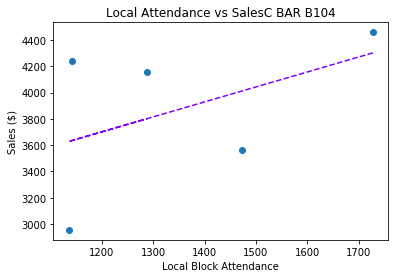

y=1.136268x+(2337.829979)



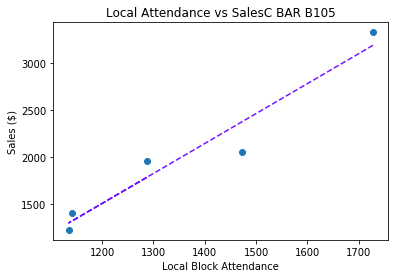

y=3.185763x+(-2318.737926)



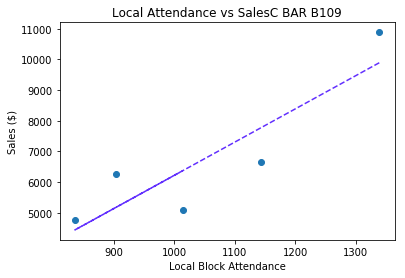

y=10.829447x+(-4609.762712)



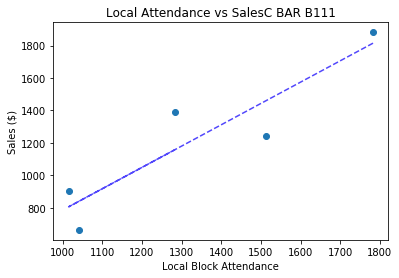

y=1.312959x+(-526.296793)



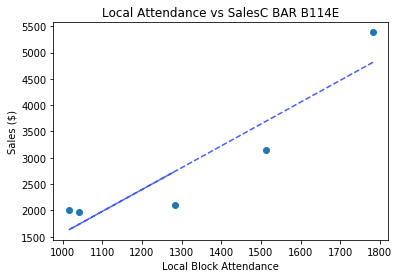

y=4.149246x+(-2583.050070)



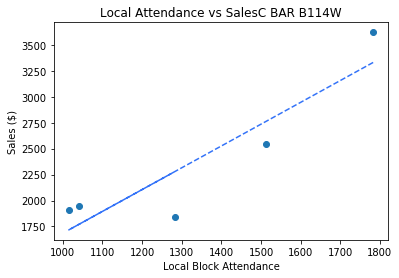

y=2.100499x+(-415.161608)



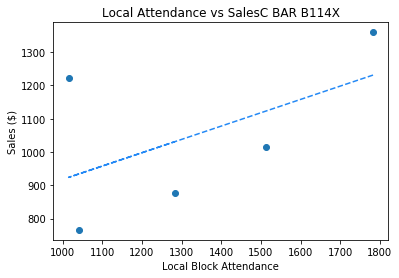

y=0.400229x+(517.696763)



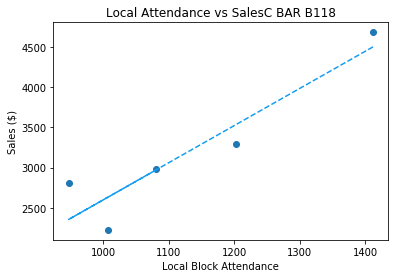

y=4.607572x+(-2006.434423)



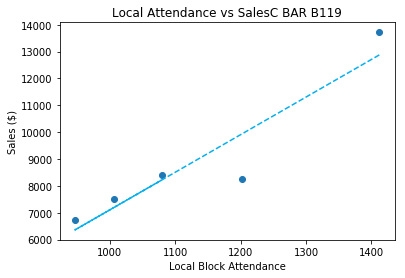

y=14.019311x+(-6919.018132)



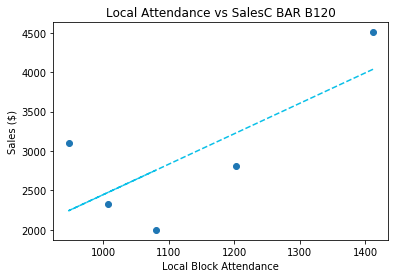

y=3.859234x+(-1412.963119)



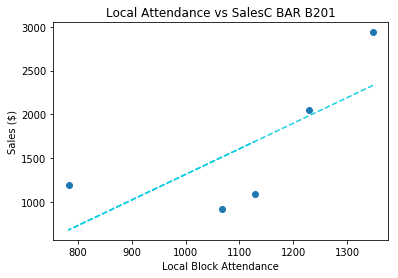

y=2.920478x+(-1605.435355)



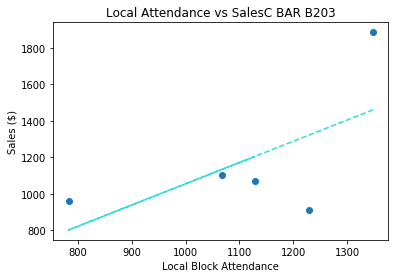

y=1.164691x+(-109.804150)



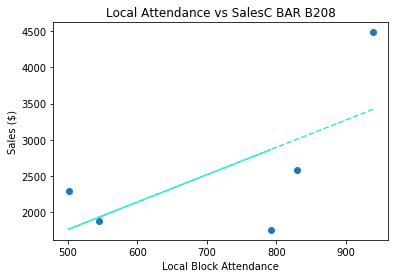

y=3.773862x+(-121.664240)



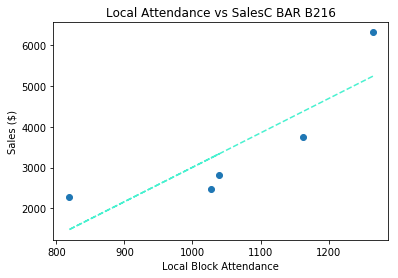

y=8.435660x+(-5429.957795)



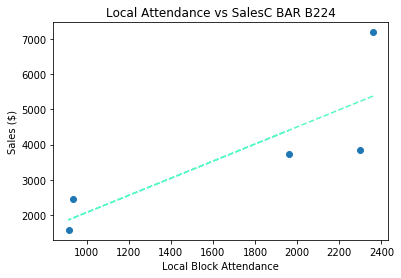

y=2.429154x+(-358.100320)



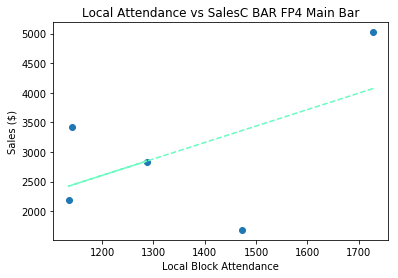

y=2.780202x+(-733.013913)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RankWarning: Polyfit may be poorly conditioned
  app.launch_new_instance()


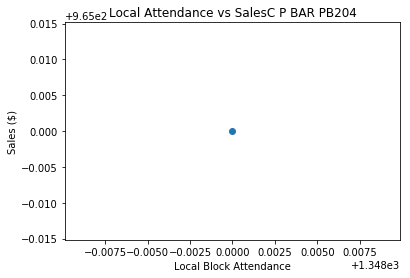

y=0.357938x+(482.500000)



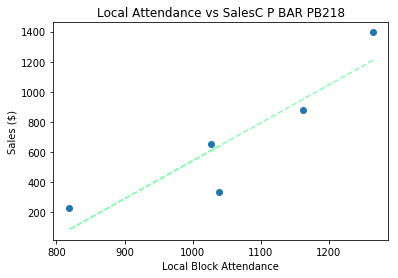

y=2.520402x+(-1978.371000)



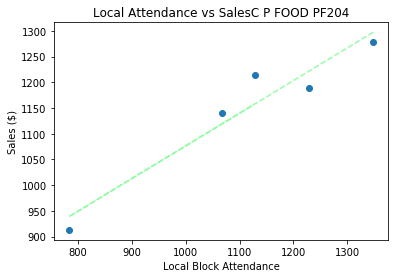

y=0.635165x+(441.205069)



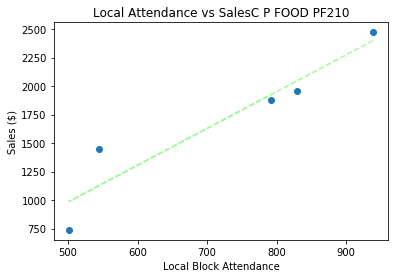

y=3.226381x+(-629.511318)



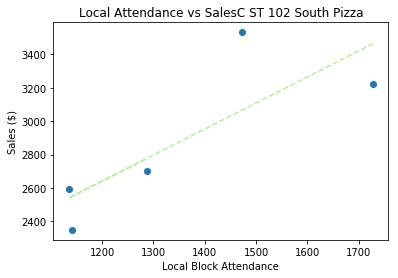

y=1.561887x+(766.167275)



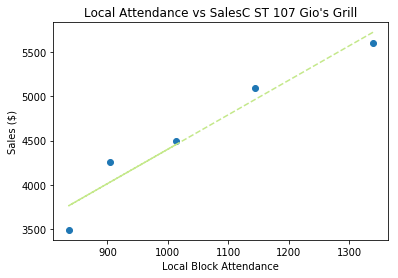

y=3.907321x+(495.271940)



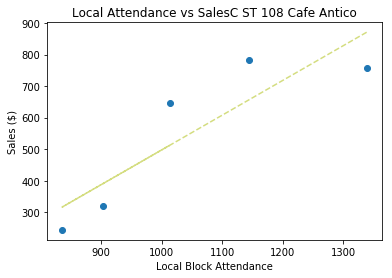

y=1.101683x+(-604.302575)



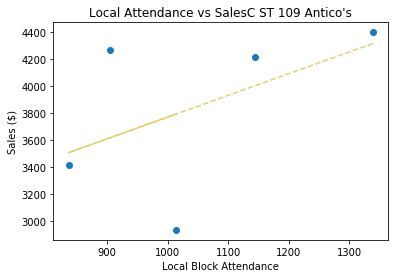

y=1.611708x+(2159.496786)



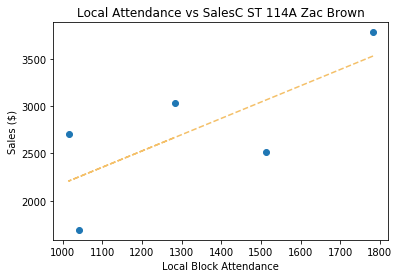

y=1.719684x+(462.579018)



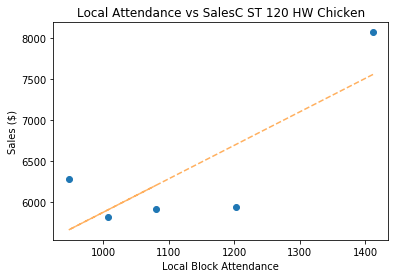

y=4.066376x+(1813.208377)



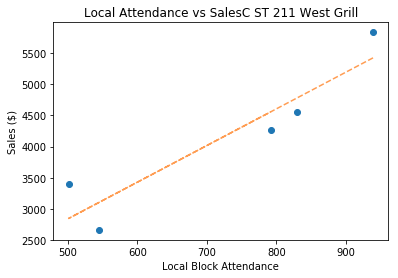

y=5.873236x+(-93.352203)



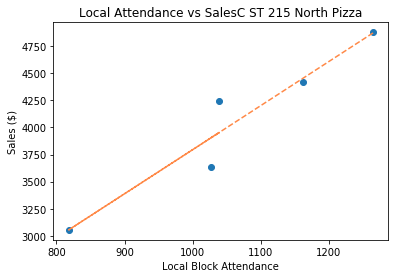

y=4.068893x+(-274.578335)



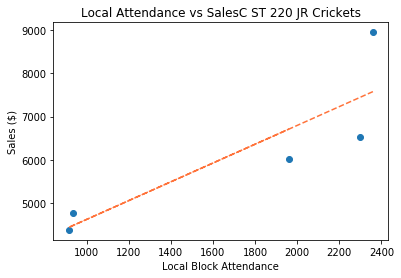

y=2.165646x+(2464.629091)



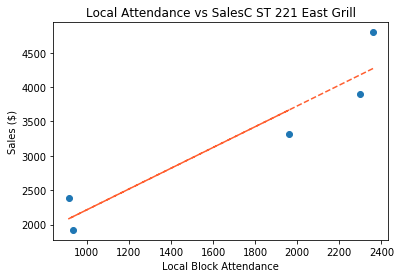

y=1.512053x+(702.085299)



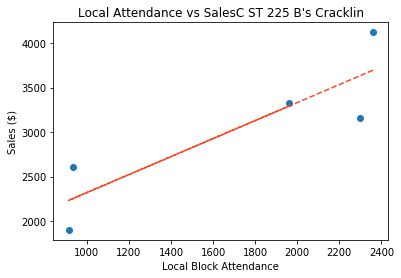

y=1.012795x+(1306.527077)



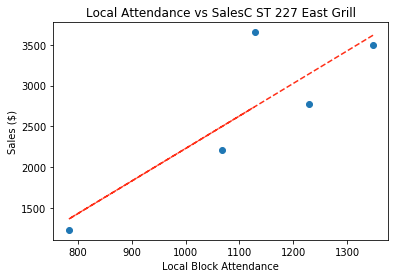

y=3.984873x+(-1755.191239)



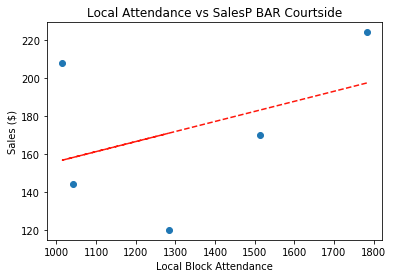

y=0.052889x+(103.016935)



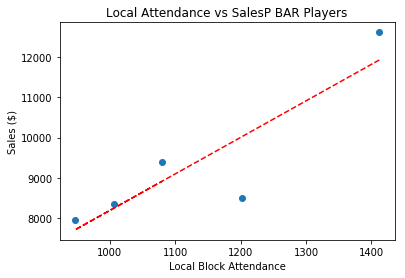

y=9.073405x+(-885.933496)



In [18]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
#plot sales vs attendance for each vendor
vendorList = mergedData['Stand'].drop_duplicates().values

color=iter(cm.rainbow(np.linspace(0,1,len(vendorList))))
for vendor in vendorList:

    c=next(color)
    vendorData = mergedData[mergedData['Stand']==vendor]
    
    x = list(vendorData['local_attendance'])
    y = list(vendorData['Sales'])
    plt.scatter(x, y)

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--",c=c)
    plt.title('Local Attendance vs Sales' + vendor)
    
    plt.xlabel('Local Block Attendance')
    plt.ylabel('Sales ($)')
    
    plt.show()
    print ("y=%.6fx+(%.6f)"%(z[0],z[1])+"\n")